# Generating CIFAR10 images with Generative adversarial networks

This notebook follows the tutorial from the website machine learning mastery on GANs:
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

This is an evolution from the previous notebooks where here we are generating color photographs. before, with MNIST the colors were only in black and white and had no color channels.

CIFAR stands for the "Canadian Institute for Advanced Research" 

We can load this dataset directly by using Keras API for tensorflow.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets.cifar10 import load_data 

Using TensorFlow backend.


In [2]:
#loading the dataset

(X_train,y_train),(X_test,y_test) = load_data()

print("train size:",X_train.shape[0],"train shape:",X_train.shape[1:])

train size: 50000 train shape: (32, 32, 3)


[8]
[9]
[0]
[1]
[9]
[4]
[8]
[0]
[8]


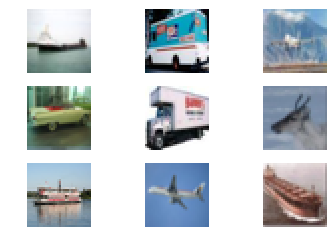

In [3]:
#showing random images
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.axis("off")
    index = np.random.randint(0,X_train.shape[0])
    plt.imshow(X_train[index])
    print(y_train[index])
plt.show()    


## Making the Discriminator Model
Since a lot of this information has been covered in the previous notebooks, we will ommit a lot of the information here and in the following notebooks. We will only keep the essentials and also focus on new details that will change with this new dataset.

Like before, we will be using CNN for both the discriminator and generator models. no pooling layers will be used and instead we will rely on 2x2 strides to effectively downsample our image as it passes the filters. We will have one more layer this time since we now have color images which have a sligtly larger resolution.

see here for a good explanation of the advatages of pooling vs stride (its all about computation and receptive field):
https://stats.stackexchange.com/questions/387482/pooling-vs-stride-for-downsampling


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.optimizers import Adam

def make_discriminator(input_shape=(32,32,3)):
    
    model = Sequential()
    #normal layer
    model.add(Conv2D(64,(3,3),padding="same",input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(256,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    
    #flatten then pass through fully connected layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation="sigmoid"))
    
    opt = Adam(lr=0.0002,beta_1=0.5)
    
    model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
    
    return model

In [0]:
# load and prepare cifar10 training images
def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    
    return X


data = load_real_samples()

In [0]:
def generate_real_samples(data,n_samples):
    
    rand_indexes = np.random.randint(0,data.shape[0],n_samples)
    
    X_samples = data[rand_indexes]
    y_samples = np.ones((n_samples,1))
    
    return X_samples,y_samples
    

In [0]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

# define the standalone generator model
def make_generator(latent_dim=100):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model


In [0]:
def generate_latent_points(n_samples,latent_dim=100):
    
    latent_points = np.random.randn(latent_dim*n_samples)
    
    latent_points = latent_points.reshape((n_samples,latent_dim))
    
    return latent_points

def generate_fake_samples(generator,n_samples,latent_dim=100):
    
    #first generate latent points, then pass them to the generator
    
    latent_points = generate_latent_points(n_samples,latent_dim)
    
    X_fake = generator.predict(latent_points)
    
    y_fake = np.zeros((n_samples,1))
    
    return X_fake,y_fake

In [0]:
def make_gan(discriminator,generator):
    
    model = Sequential()
    
    discriminator.trainable = False
    
    model.add(generator)
    
    model.add(discriminator)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy",optimizer=opt)
    
    return model




In [0]:
 discriminator = make_discriminator()
generator = make_generator()

gan = make_gan(discriminator,generator)


In [20]:
import time

def train_gan(data,gan,discriminator,generator,n_epochs=100,batch_size=256):
    batch_per_epoch = int(data.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    
    n_points = 9
    fixed_latent_points = generate_latent_points(n_points)
    train_images = []
    
    gan_loss = []
    disc_loss = []
    
    for epoch in range(n_epochs):
        print("starting epoch",epoch)
        start_time = time.time()
        
        for batch in range(batch_per_epoch):
            
            #train the discriminator
            X_real,y_real = generate_real_samples(data,half_batch)
            X_fake,y_fake = generate_fake_samples(generator,half_batch)
            
            X,y = np.vstack((X_real,X_fake)) , np.vstack((y_real, y_fake))
            
            d_loss, _ = discriminator.train_on_batch(X,y)
            
            #train the generator (through the gan model by using the discriminator's error)
            lat_points = generate_latent_points(batch_size)
            y_gan = np.ones((batch_size,1))
            
            g_loss = gan.train_on_batch(lat_points,y_gan)
            
            
            #paint some pictures
            if epoch % 10 == 0:
                imgs = generator.predict(fixed_latent_points)

                #renormalize images for easy printing
                imgs = (imgs + 1) / 2.0
                train_images.append(imgs)
                
                #add loss to storage for graphing
                
                gan_loss.append(g_loss)
                disc_loss.append(d_loss)
            
            stop_time = time.time()
            
        print("epoch",epoch,"finished in",stop_time - start_time,"s")
            
            
    return train_images,gan_loss,disc_loss


reset_train =False

if reset_train:    
    discriminator = make_discriminator()
    generator = make_generator()

    gan = make_gan(discriminator,generator)



train_images,gan_loss,disc_loss = train_gan(data,gan,discriminator,generator)            
            
            

starting epoch 0


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch 0 finished in 28.596174240112305 s
starting epoch 1
epoch 1 finished in 28.94871759414673 s
starting epoch 2
epoch 2 finished in 29.733219623565674 s
starting epoch 3
epoch 3 finished in 29.907952547073364 s
starting epoch 4
epoch 4 finished in 29.678022861480713 s
starting epoch 5
epoch 5 finished in 29.675374031066895 s
starting epoch 6
epoch 6 finished in 29.68024516105652 s
starting epoch 7
epoch 7 finished in 29.694711446762085 s
starting epoch 8
epoch 8 finished in 29.785010814666748 s
starting epoch 9
epoch 9 finished in 29.82025957107544 s
starting epoch 10
epoch 10 finished in 30.179343700408936 s
starting epoch 11
epoch 11 finished in 29.79042911529541 s
starting epoch 12
epoch 12 finished in 29.81320810317993 s
starting epoch 13
epoch 13 finished in 29.830737113952637 s
starting epoch 14
epoch 14 finished in 29.757017850875854 s
starting epoch 15
epoch 15 finished in 29.73987889289856 s
starting epoch 16
epoch 16 finished in 29.723459720611572 s
starting epoch 17
epoch

In [0]:
save_models = True

if save_models:
    filenames = ["generator_model.h5","discriminator_model.h5"]
    generator.save(filenames[0])
    discriminator.save(filenames[1])


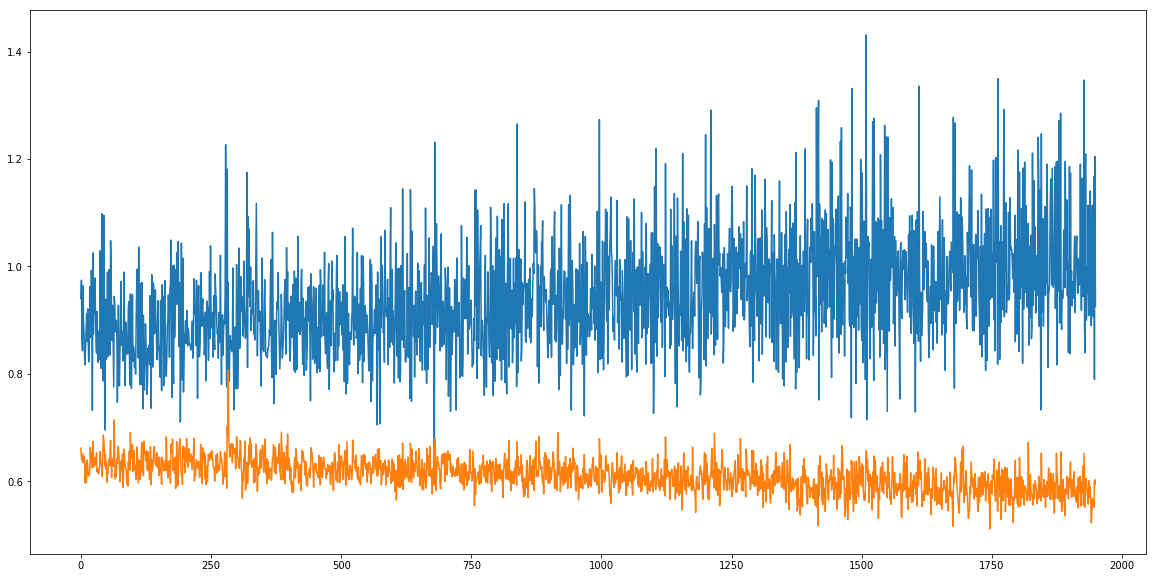

In [21]:
plt.figure(figsize=(20,10))

plt.plot(gan_loss)
plt.plot(disc_loss)

plt.show()

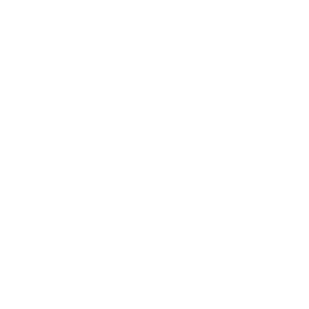

In [12]:
from matplotlib import animation

ims = []
fig = plt.figure()
ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
ax.set_xticks([]); ax.set_yticks([])

for train_ims in train_images:

    

    im_1 = plt.imshow(train_ims[0,:,:],vmin=0, vmax=1, animated=True) #add first image for test
    
    ims.append([im_1])
    #plt.pause(0.1) 

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)


anim = animation.ArtistAnimation(fig,ims)
anim.save("test_gif_3.mp4", writer= writer)

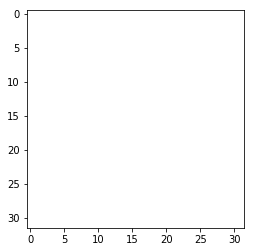

In [22]:
from matplotlib import animation

ims = []
fig = plt.figure()
ax1 = fig.add_subplot()
ax2 = fig.add_subplot()
"""
ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
ax.set_xticks([])
ax.set_yticks([])
"""

for train_ims in train_images:

    

    im_1 = plt.imshow(train_ims[5,:,:],vmin=0, vmax=1, animated=True) #add first image for test
    
    ims.append([im_1])
    #plt.pause(0.1) 

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)


anim = animation.ArtistAnimation(fig,ims)
anim.save("test_gif_3.mp4", writer= writer)

(3, 3)


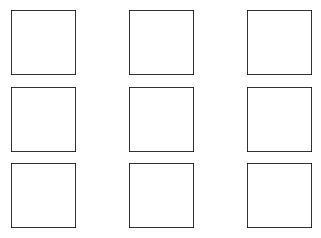

In [23]:
fig,axs = plt.subplots(3,3)

print(axs.shape)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

images = []

#iterate ove images
for imgs in train_images:
    ims = [] 
    for i,img in enumerate(imgs):
        
        line = i%3
        col = int(i/3)
        ims.append(axs[line,col].imshow(img[:,:],vmin=0, vmax=1, animated=True))
    
    images.append(ims)

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.ArtistAnimation(fig,images)
anim.save("train_grid.mp4", writer= writer)


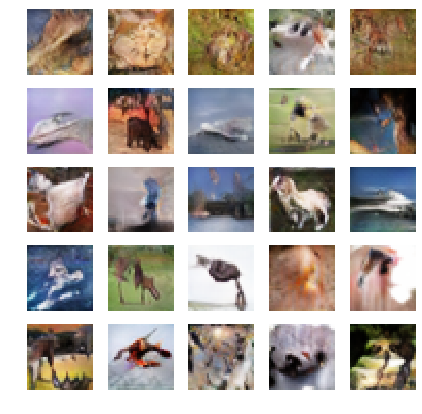

In [27]:
samples =25

fake_ims,_ = generate_fake_samples(generator,samples)

fake_ims = (fake_ims+1)/2.0

plt.figure(figsize=(7,7))

for i in range(samples):
    
    plt.subplot(5,5,i+1)
    
    plt.axis("off")
    
    plt.imshow(fake_ims[i, : , :] )
plt.show()